In [1]:
""" import useful functions """

import os

# Generic
import pandas as pd
import numpy as np
import scipy
from itertools import islice, cycle
import math
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed
import itertools
from importlib import reload
from functools import lru_cache
import scipy.integrate

# cosmology
import pyccl as ccl
from astropy.io import fits
import yaml
import sacc
import time

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# SRD Binning
import srd_redshift_distributions as srd
import binning

# Data Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
#import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from chainconsumer import ChainConsumer, Chain, make_sample
from IPython.display import display, Math
from multiprocessing import Pool
from tqdm import tqdm

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor

# f(R) emu (eMANTIS)
from emantis import FofrBoost

In [17]:
from LikelihoodFuncts_PCADR_noparam import *

Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
# Define cosmology
cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)


fR_universe = 0.0
H0rc_universe = 0.0
MGParam_universe = [H0rc_universe,fR_universe,0,0,0]

In [19]:
#### Run to get the data and covariance (with scale cuts) to put into the likelihood function
command = 'python Get_Data_3x2pt_fsigma8_ESS.py --OmgC {} --OmgB {} --h {} --ns {} --As {}'.format(cosmo_universe["Omega_c"],cosmo_universe["Omega_b"],cosmo_universe["h"], cosmo_universe["n_s"],cosmo_universe["A_s"])
os.system(command)


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data
starting code
collecting data
No scale cuts - we are using GR cuts


0

In [359]:
### Load and collect the data for likelihood
#npzfile = np.load("../Biases_parametrization/Data_storage_fR.npz")
npzfile = np.load("Data_storage_ESS_partial_Sigma1.npz")

npzfile_GR = np.load("../Parameter_inference_GR/Data_storage_GR.npz")

C_ell_data_mock = [npzfile['C_ell_data'],npzfile['ell_data'],npzfile['z'],npzfile['Binned_distribution_source'],\
                    npzfile['Binned_distribution_lens'],20,1478.5,13]



Data_fsigma8= [npzfile['z_eff_fsigma8'], npzfile['fsigma8_data'],np.matrix(npzfile['invcov_fsigma8'])]

L_choleski_inv = np.matrix(npzfile_GR['L_ch_inv'])

gauss_invcov_rotated = np.matrix(npzfile_GR['Inverse_cov'])

## Plot to check data/covariance

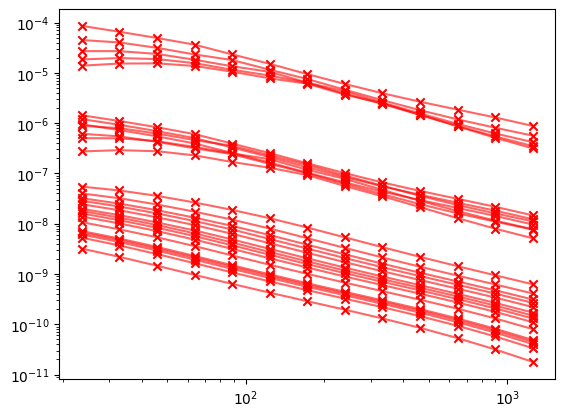

In [360]:
## Plot to check 3x2pt data

plt.scatter(C_ell_data_mock[1],C_ell_data_mock[0], color="r", marker='x')

for j in range(27):
    plt.plot(C_ell_data_mock[1][j*13:(j+1)*13], C_ell_data_mock[0][j*13:(j+1)*13], "r", alpha=0.6)

plt.xscale("log")
plt.yscale("log")

NameError: name 'mu_ESS_C' is not defined

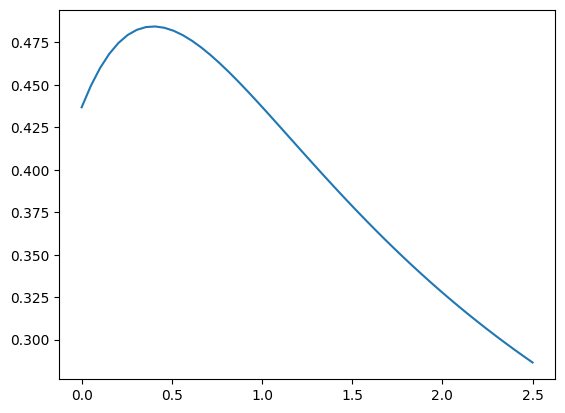

In [9]:
## Plot to check fsigma8 data
P_delta2D_GR_lin_universe = Get_Pk2D_obj_kk_GR_lin(cosmo_universe)

plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_musigma(P_delta2D_GR_lin_universe,cosmo_universe, [0,0,0,0,0], 1/(np.linspace(0.0, 2.5, 50)+1)))
plt.plot(np.linspace(0.0, 2.5, 50), fsigma8_ESS_C(cosmo_universe, [0,0,0,0,0], 1/(np.linspace(0.0, 2.5, 50)+1)))
#plt.errorbar(Data_fsigma8[0][:-1], fsigma_8_realdata, yerr=fsigma_8_realdata*fsigma_8_fracerror[:-1], fmt="o", color="r")
plt.errorbar(Data_fsigma8[0], Data_fsigma8[1], yerr=np.sqrt(np.diag(np.linalg.inv(Data_fsigma8[2]))), fmt="o", color="g")
plt.errorbar(Data_fsigma8[0][-1], Data_fsigma8[1][-1], yerr=np.sqrt(np.diag(np.linalg.inv(Data_fsigma8[2])))[-1], fmt="o", color="k", label = "DESI, sim")
print(Data_fsigma8[0])

plt.xlabel("z")
plt.ylabel(r"$f \sigma_8(z)$")
plt.legend()

87


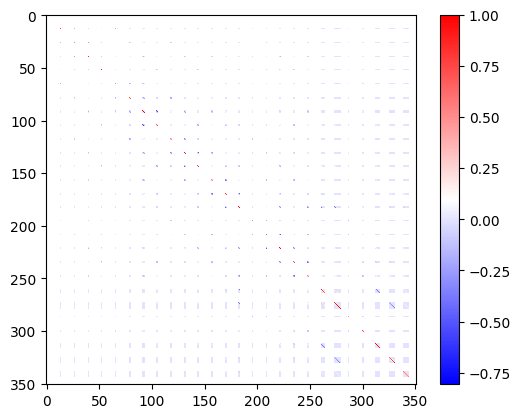

In [370]:
## Plot correlation matrix (scale cuts)

plt.imshow(cov2corr(gauss_invcov_rotated), origin='upper',  cmap='bwr')

print(np.sum(np.any(gauss_invcov_rotated != 0, axis=1)))
plt.colorbar()
plt.show()

(351, 351)
254


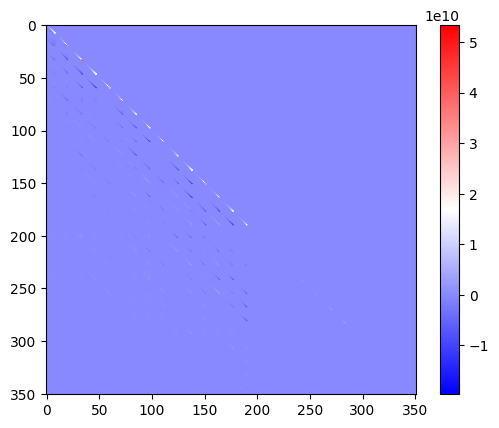

In [371]:
## Plot to choleski matrix (scale cuts)

print(L_choleski_inv.shape)
plt.imshow((L_choleski_inv), origin='upper',  cmap='bwr')
print(np.sum(np.any(L_choleski_inv != 0, axis=1)))

plt.colorbar()
plt.show()

(351, 351)


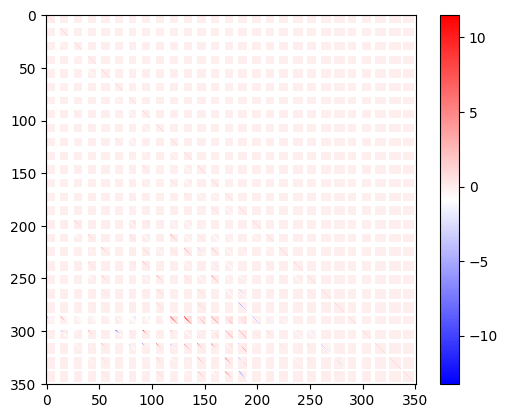

In [372]:
print(L_choleski_inv.shape)
plt.imshow(cov2corr(L_choleski_inv), origin='upper',  cmap='bwr')

plt.colorbar()
plt.show()

### Test boost plots

In [4]:
ESS_Boost = np.load('/home/c2042999/PCA_project/HiCOLA_files/Output/Boost.npy')
ESS_z_temp = np.loadtxt('/home/c2042999/PCA_project/HiCOLA_files/Output/z_k.txt').T
ESS_z = ESS_z_temp[0][~np.isnan(ESS_z_temp[0])]

In [10]:

Pk_test = []
for i in range(50):
    Pk_test.append(P_k_NL_nDGP(P_delta2D_GR_lin_universe,cosmo_universe, [0.2,0,0,0,0], np.array([0.1,0.1]), np.linspace(1/3, 1, 50)[i])[0])

Text(0, 0.5, 'Boost, varying k')

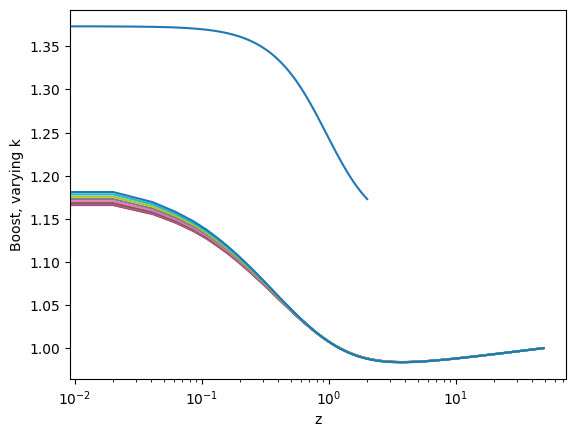

In [11]:
plt.semilogx(1/np.linspace(1/3, 1, 50) -1,Pk_test/ccl.nonlin_matter_power(cosmo_universe, 0.1, np.linspace(1/3, 1, 50)))

for i in range(10):
    plt.semilogx(ESS_z,ESS_Boost[:,i])

plt.xlabel("z")
plt.ylabel("Boost, varying k")

In [12]:
ESS_funcs = np.loadtxt('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_force.txt').T

ESS_mu_interp = ESS_funcs[2] + 1
ESS_a_interp = ESS_funcs[0]

Text(0, 0.5, 'mu(z)')

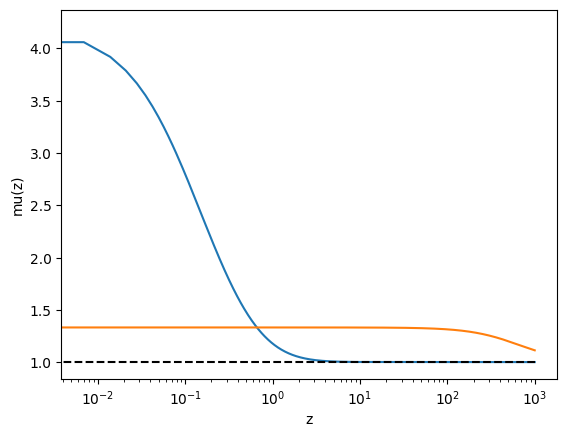

In [13]:
plt.semilogx(1/ESS_a_interp - 1,ESS_mu_interp)
plt.semilogx(1/ESS_a_interp - 1,mu_nDGP([1e-4,0,0,0,0], cosmo_universe, ESS_a_interp))

plt.semilogx(1/ESS_a_interp - 1,np.ones(len(ESS_a_interp)), "k--")

plt.xlabel("z")
plt.ylabel("mu(z)")

### Test sigma8 consistency

In [363]:

"""ESS, ~LCDM background (from HiCOLA)"""
# Load the saved array from HiCOLA, function of z and k
ESS_C_Boost_loaded = np.load('/home/c2042999/PCA_project/HiCOLA_files/Output/Boost.npy')

z_k_arr_loaded = np.loadtxt('/home/c2042999/PCA_project/HiCOLA_files/Output/z_k.txt')
ESS_C_z_loaded = z_k_arr_loaded.T[0][~np.isnan(z_k_arr_loaded.T[0])]
ESS_C_k_loaded = z_k_arr_loaded.T[1]

# NL matter power spectra
interpolator_ESS_C_funct = RectBivariateSpline(ESS_C_z_loaded, ESS_C_k_loaded, ESS_C_Boost_loaded)

def P_k_NL_ESS_C(cosmo, k, a):
    
    pkratio_ESS_C = interpolator_ESS_C_funct(1/a - 1, k/cosmo["h"]) # k is in units [h/Mpc]

    Pk_ccl = ccl.power.nonlin_power(cosmo, k, a=a) # units (Mpc)^3
    Pk = pkratio_ESS_C.reshape(Pk_ccl.shape)*Pk_ccl

    return Pk

def P_k_ESS_C_lin(cosmo, k, a):
    
    pkratio_ESS_C = interpolator_ESS_C_funct(1/a - 1, 0.020046/cosmo["h"])[0] # k is in units [h/Mpc]
    Pk_ccl = ccl.linear_matter_power(cosmo, k, a=a) # units (Mpc)^3
    Pk = pkratio_ESS_C*Pk_ccl

    return Pk

"""ESS"""
def mu_ESS_C(a):

    force_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_force.txt")

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    return np.interp(a, a_today, coupling + 1)
        
# No LCDM background
def sigma_8_ESS_C(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_ESS_C_lin(cosmo, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

def solverGrowth_ESS_C(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    mu = mu_ESS_C(a)
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    
def fsigma8_ESS_C(cosmoMCMCStep, MGparams, a):
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_ESS_C, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]

    f_ESS_C_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_ESS_C = np.interp(a, a_solver, f_ESS_C_interp)

    k_val = np.logspace(-4,3,3000)
    return f_ESS_C * sigma_8_ESS_C(cosmoMCMCStep, MGparams, a)


In [352]:
def solverGrowth_musigma_test(y,a,cosmoMCMCStep, MGparams):
    E_val = E(cosmoMCMCStep, a)
    D , a3EdDda = y

    mu = mu_ESS_C(a)
    Sigma = sigma_lin_param(MGparams, cosmoMCMCStep, a)
    eta = 1#2*Sigma/mu - 1
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmoMCMCStep["Omega_m"]*D*(mu/eta)/(2*E_val*a**2)]
    return ydot
    
def P_k_musigma_tests(cosmoMCMCStep, MGparams, k, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma_test, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmoMCMCStep,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    Pk_GR = ccl.power.linear_matter_power(cosmoMCMCStep,k, a)

    # find the index for matter domination)
    idx_mdom = np.argmax(a_solver**(-3) / E(cosmoMCMCStep, a_solver)**2)          
    # get normalization at matter domination
    Delta_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3

def sigma_8_musigma_tests(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_musigma_tests(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)

    return np.array(sigma_8_vals)
        
def fsigma8_musigma_tests(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu, Sigma])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in musigma
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma_test, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]
    
    f_musigma_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_musigma = np.interp(a, a_solver, f_musigma_interp)
    
    return f_musigma * sigma_8_musigma_tests(cosmoMCMCStep, MGparams, a)

0.9350719790806066
0.8217372540568159
0.8217372540568159
0.9358882802598291
0.0 0.020046


Text(0, 0.5, 'sigma8')

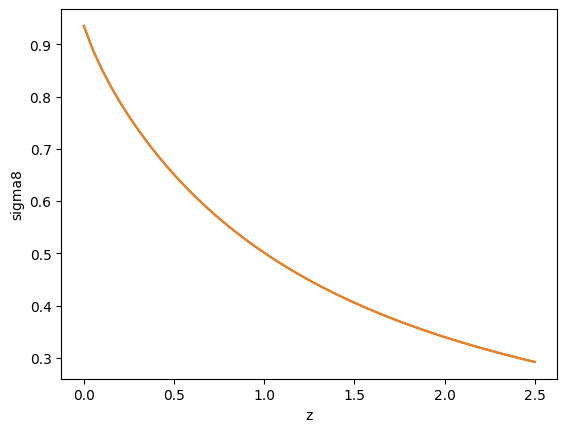

In [340]:

a_array = 1/(np.linspace(0.0, 2.5, 50)+1)
plt.plot(1/a_array -1,sigma_8_ESS_C(cosmo_universe, [0,0,0,0,0], a_array))

print(sigma_8_ESS_C(cosmo_universe, [0,0,0,0,0], [1,1])[0])
print(ccl.sigma8(cosmo_universe))
print(ccl.power.sigmaR(cosmo_universe,8/cosmo_universe["h"],a=1))
print(ccl.sigma8(cosmo_universe)*np.sqrt(ESS_C_Boost_loaded[0,0]))
print(ESS_C_z_loaded[0],ESS_C_k_loaded[0])

sigma8_val = []
for i in range(len(a_array)):
    sigma8_val.append(ccl.power.sigmaR(cosmo_universe,8/cosmo_universe["h"],a=a_array[i]))

plt.plot(1/a_array -1,np.sqrt(interpolator_ESS_C_funct(1/a_array - 1, 0.020046/cosmo_universe["h"])).T[0]*sigma8_val)

plt.xlabel("z")
plt.ylabel("sigma8")


Text(0, 0.5, 'sigma8, nDGP')

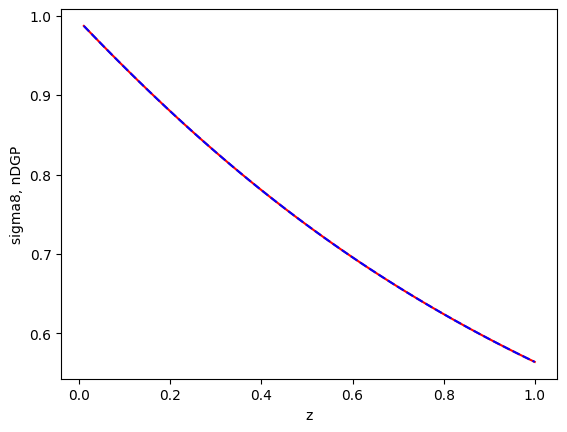

In [341]:
P_delta2D_GR_lin_universe = Get_Pk2D_obj_kk_GR_lin(cosmo_universe)

a_array = 1/(np.linspace(0.01, 1.0, 50)+1)
plt.plot(1/a_array-1,sigma_8_nDGP(P_delta2D_GR_lin_universe,cosmo_universe, [0.2,0,0,0,0], a_array), "r")


sigma8_val = []
for i in range(len(a_array)):
    sigma8_val.append(ccl.power.sigmaR(cosmo_universe,8/cosmo_universe["h"],a=a_array[i]))

Boost_ratio_test = P_k_nDGP_lin(P_delta2D_GR_lin_universe,cosmo_universe,[0.2,0,0,0,0],0.5,a_array)/P_delta2D_GR_lin_universe.__call__(0.5,a_array)

plt.plot(1/a_array -1,np.sqrt(Boost_ratio_test)*sigma8_val, "b--")

plt.xlabel("z")
plt.ylabel("sigma8, nDGP")

### Test boost consistency with mu(a)

Text(0, 0.5, 'growth rate f')

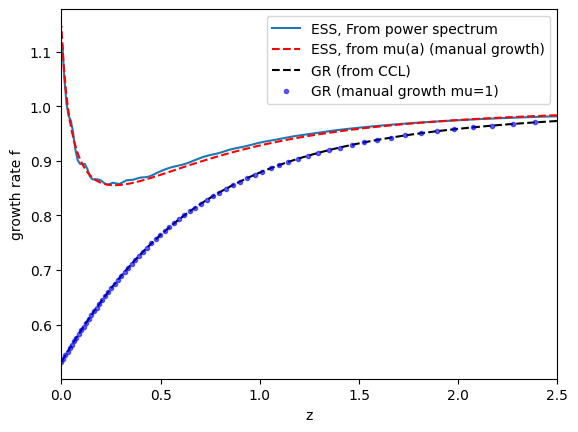

In [342]:
a_solver = np.linspace(1/300,1,100)
Soln = odeint(solverGrowth_ESS_C, [a_solver[0], (E(cosmo_universe, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo_universe,[0,0,0,0,0]), mxstep=int(1e4))
    
Delta = Soln.T[0]
dDda_test = Soln.T[1]
idx_mdom = np.argmax(a_solver**(-3) / E(cosmo_universe, a_solver)**2)          
#idx_mdom = 0
# get normalization at matter domination
Delta_ESS_49 = Delta[idx_mdom]

Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo_universe, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo_universe,[0,0,0,0,0]), mxstep=int(1e4))
    
Delta_GR = Soln.T[0]
dDda_test_GR = Soln.T[1]

# Get Pk linear in GR

Delta_GR_49 = Delta_GR[idx_mdom]


Boost_lin_test = np.flip(interpolator_ESS_C_funct(1/np.flip(a_solver) - 1, np.ones(len(a_solver))*0.020046/cosmo_universe["h"]).T[0])

#plt.plot(1/a_solver - 1, Delta/Delta_ESS_49, "r")
Delta_newattempt = np.sqrt(Boost_lin_test) * (Delta_GR / Delta_GR_49)
der = np.diff(Delta_newattempt) / np.diff(a_solver)
a_solver2 = (a_solver[:-1] + a_solver[1:]) / 2
Delta_newattempt2 = (Delta_newattempt[:-1] + Delta_newattempt[1:]) / 2

plt.plot(1/a_solver2 - 1,a_solver2*der/Delta_newattempt2)

plt.plot(1/a_solver - 1,dDda_test/a_solver**2 / Delta / E(cosmo_universe, a_solver), "r--")
plt.plot(1/a_solver - 1,ccl.growth_rate(cosmo_universe, a_solver), "k--", alpha=1)
plt.plot(1/a_solver - 1,dDda_test_GR/a_solver**2 / Delta_GR / E(cosmo_universe, a_solver), "b.", alpha=0.6)

# a/D dD/da
plt.xlim(0,2.5)
plt.legend(['ESS, From power spectrum', 'ESS, from mu(a) (manual growth)', 'GR (from CCL)', 'GR (manual growth mu=1)'])
plt.xlabel("z")
plt.ylabel("growth rate f")

Text(0, 0.5, 'fsigma8')

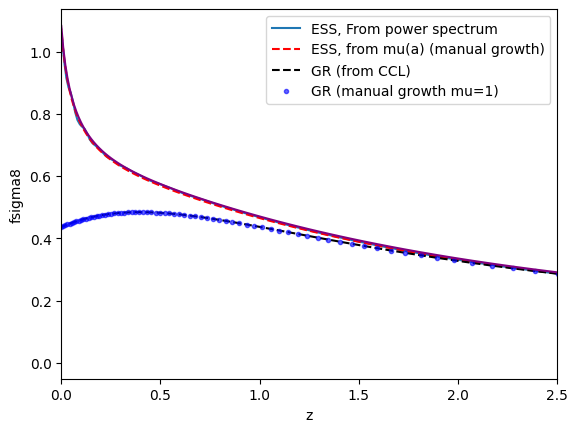

In [353]:
a_solver = np.linspace(1/300,1,100)
Soln = odeint(solverGrowth_ESS_C, [a_solver[0], (E(cosmo_universe, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo_universe,[0,0,0,0,0]), mxstep=int(1e4))
    
Delta = Soln.T[0]
dDda_test = Soln.T[1]
idx_mdom = np.argmax(a_solver**(-3) / E(cosmo_universe, a_solver)**2)          
#idx_mdom = 0
# get normalization at matter domination
Delta_ESS_49 = Delta[idx_mdom]

Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo_universe, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo_universe,[0,0,0,0,0]), mxstep=int(1e4))
    
Delta_GR = Soln.T[0]
dDda_test_GR = Soln.T[1]

# Get Pk linear in GR

Delta_GR_49 = Delta_GR[idx_mdom]


Boost_lin_test = np.flip(interpolator_ESS_C_funct(1/np.flip(a_solver) - 1, np.ones(len(a_solver))*0.020046/cosmo_universe["h"]).T[0])

#plt.plot(1/a_solver - 1, Delta/Delta_ESS_49, "r")
Delta_newattempt = np.sqrt(Boost_lin_test) * (Delta_GR / Delta_GR_49)
der = np.diff(Delta_newattempt) / np.diff(a_solver)
a_solver2 = (a_solver[:-1] + a_solver[1:]) / 2
Delta_newattempt2 = (Delta_newattempt[:-1] + Delta_newattempt[1:]) / 2

## sigma8 gr
sigma8_val = []
for i in range(len(a_solver)):
    sigma8_val.append(ccl.power.sigmaR(cosmo_universe,8/cosmo_universe["h"],a=a_solver[i]))


plt.plot(1/a_solver2 - 1,a_solver2*der/Delta_newattempt2 *sigma_8_ESS_C(cosmo_universe, [0,0,0,0,0], a_solver2))

plt.plot(1/a_solver - 1,dDda_test/a_solver**2 / Delta / E(cosmo_universe, a_solver) *sigma_8_ESS_C(cosmo_universe, [0,0,0,0,0], a_solver), "r--")
plt.plot(1/a_solver - 1,ccl.growth_rate(cosmo_universe, a_solver)*sigma8_val, "k--", alpha=1)
plt.plot(1/a_solver - 1,dDda_test_GR/a_solver**2 / Delta_GR / E(cosmo_universe, a_solver) * sigma8_val, "b.", alpha=0.6)

fsigma8_mu_test = fsigma8_musigma_tests(cosmo_universe, [0,0,0,0,0], a_solver)
plt.plot(1/a_solver - 1,fsigma8_mu_test, "purple")
# a/D dD/da
plt.xlim(0,2.5)
plt.legend(['ESS, From power spectrum', 'ESS, from mu(a) (manual growth)', 'GR (from CCL)', 'GR (manual growth mu=1)'])
plt.xlabel("z")
plt.ylabel("fsigma8")

In [212]:
# check that using mu(a) for ESS to get P(k) is the same as linear P(k) we have

def P_k_ESS_C_lin_testalternative(cosmo, k, a):
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_ESS_C, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    
    Pk_GR = ccl.linear_matter_power(cosmo, k, a=a)

    # find the index for matter domination)
    idx_mdom = np.argmax(a_solver**(-3) / E(cosmo, a_solver)**2)          
    #idx_mdom = 0
    # get normalization at matter domination
    Delta_ESS_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_ESS_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3

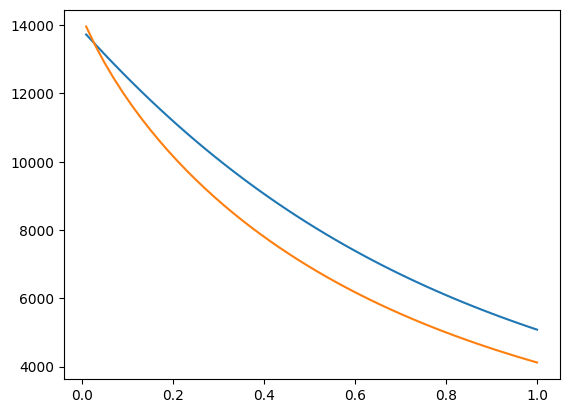

In [213]:
a_array = 1/(np.linspace(0.01, 1.0, 50)+1)

plt.plot(1/a_array - 1,P_k_ESS_C_lin(cosmo_universe, 0.1,a_array))
plt.plot(1/a_array - 1,P_k_ESS_C_lin_testalternative(cosmo_universe,0.1, a_array))
